In [1]:
# This is the start of a new code to analyze RNA-seq bulk data from a normalized table downloaded from:
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145936

# DATE: April 26, 2024
# LAST MODIFIED ON:  May 03, 2024
# BY: Leo Lagunes

# The goal of this script is to plot the gene expression leves of proteasome genes and Rpn4 over time 
# In the study this data came from, they heat-shocked yeast and measured gene expression levels at different time points:
# "We performed 12 RNA seq of polyA+ mRNA from yeast cells over two time courses: following heat shock at 39C and following 
    # nuclear depletion of the J-protein Sis1 using the "anchor away" approach. For both time series, the time points were 
    # 0, 15, 30, 60, 90 and 120 minutes." (the first 6 HS time points!)
     

In [1]:
# === PACKAGES NEEDED === 

import numpy as np # for mathematical computing
from scipy.integrate import odeint # for ode solving
import matplotlib.pyplot as plt # for plotting 
import math  # for other math functions
from scipy.integrate import solve_ivp  # for ode solving
import seaborn as sns # for the heatmaps
from datetime import date # to print date
from datetime import datetime # to print data
import pandas as pd # to read txt file
import csv # to open csv file 

# datetime object containing current date and time
now = datetime.now()
now = datetime.now(); dt_string = now.strftime("%m/%d/%Y %H:%M:%S")
today_pre = date.today()
today = today_pre.strftime("%m_%d_%y")

print('All packages loaded on ', dt_string)


All packages loaded on  05/03/2024 15:08:30


In [2]:
# ==== FUNCTIONS ===
# These are all the user-defined functions I will need

# --- gather all the data needed --- 
def obtainAllData(CPgenesNames,RPgeneNames,alphaGeneNames, betaGeneNames,rpnsGeneNames,rptsGeneNames):
    # load txt matrix which is in the data folder 
    # this .csv file has only the genes of interest - I removed all the other genes since I only need those 
    # associated with the proteasome (and Rpn4)
    X = pd.read_csv('Data/Gene_counts_normalized_reduced.csv', sep="\t", header=None)

    geneExprList_tot = []; geneLabels = []; 
    CPgenesList=[]; RPgenesList=[];alphaCPList = []; betaCPList = [];rpns_RPList = []; rpts_RPList = [];
    #print(X)
    with open('Data/Gene_counts_normalized_reduced.csv', 'r') as fd:
        reader = csv.reader(fd)
        for row in reader:
            # print(row)
            # store gene names
            geneRowI = row[1];
            geneLabels.append(geneRowI)
            # add to a new array as a float (currently as string)
            el2add = row[2:8]; res = [float(ele) for ele in el2add]; # need the gene name and the first 6 time point readings
            geneExprList_tot.append(res)
            # --- store gene expression labels based on CP or RP --- 
             # --- store gene expression labels based on CP or RP --- 
            if geneRowI in CPgenesNames:
                # store in CP 
                #print("CP gene: ", geneRowI)
                cpGeneIn = row[2:8]; resCP = [float(ele) for ele in cpGeneIn];
                CPgenesList.append(resCP)
            elif geneRowI in RPgenesList:
                # store in RP
                rpGeneIn = row[2:8]; resRP = [float(ele) for ele in rpGeneIn];
                RPgenesList.append(resRP)
            # --- store gene expressions based on alpha or beta --- 
            if geneRowI in alphaGeneNames: 
                # store in alpha 
                cpAlphaGeneIn = row[2:8]; resCPalpha = [float(ele) for ele in cpAlphaGeneIn];
                alphaCPList.append(resCPalpha)
            elif geneRowI in betaGeneNames:
                # store in beta 
                cpBetaGeneIn = row[2:8]; resCPbeta = [float(ele) for ele in cpBetaGeneIn];
                betaCPList.append(resCPbeta)
            # --- store gene expressions based on rpn's or rpt's --- 
            if geneRowI in rpnsGeneNames: 
                # store in rpns 
                rpnGeneIn = row[2:8]; resRPn = [float(ele) for ele in rpnGeneIn];
                rpns_RPList.append(resRPn)
            elif geneRowI in rptsGeneNames:
                # store in rpts 
                rptGeneIn = row[2:8]; resRPt = [float(ele) for ele in rptGeneIn];
                rpts_RPList.append(resRPt)
      
    return geneExprList_tot, CPgenesList, RPgenesList, alphaCPList,betaCPList,rpns_RPList, rpts_RPList,geneLabels

print('All function ready on ', dt_string)

All function ready on  05/03/2024 15:08:30


Figure saved!


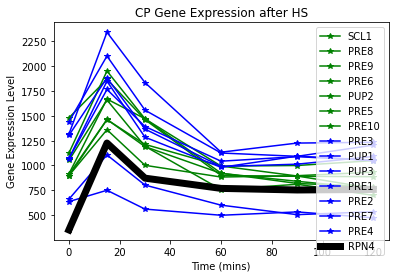

In [3]:
# === RUNNING CODE ===
# This is the code I will need to run to get that time course 
CPgenesNames = ['SCL1', 'PRE8', 'PRE9','PRE6', 'PUP2', 'PRE5', 'PRE10', 'PRE3', 'PUP1', 'PUP3', 'PRE1', 'PRE2', 'PRE7', 'PRE4']
RPgeneNames = ['RPN1', 'RPN2', 'RPN3','RPN5', 'RPN6','RPN7','RPN8', 'RPN9', 'RPN10', 'RPN11', 'RPN12','RPN13', 'RPN14', 'RPT1', 'RPT2', 'RPT3', 'RPT4', 'RPT5', 'RPT6']


alphaGeneNames = ['SCL1', 'PRE8', 'PRE9','PRE6', 'PUP2', 'PRE5', 'PRE10'];
betaGeneNames = [ 'PRE3', 'PUP1', 'PUP3', 'PRE1', 'PRE2', 'PRE7', 'PRE4'];

rpnsGeneNames = ['RPN1', 'RPN2', 'RPN3','RPN5', 'RPN6','RPN7','RPN8', 'RPN9', 'RPN10', 'RPN11', 'RPN12','RPN13', 'RPN14']
rptsGeneNames = ['RPT1', 'RPT2', 'RPT3', 'RPT4', 'RPT5', 'RPT6']
# call all CP and RP gene expressions
allLists = obtainAllData(CPgenesNames,RPgeneNames, alphaGeneNames, betaGeneNames,rpnsGeneNames,rptsGeneNames)
geneExprList_tot = allLists[0]
alpha_cp_gene_expression = allLists[3]; beta_cp_gene_expression = allLists[4];
rpnsGeneExpr = allLists[5]; rptsGeneExpr = allLists[6]; 
allGeneLabels = allLists[-1]

# plot gene expression list for all genes 
x = [0, 15, 30, 60, 90 ,120] # in minutes
rpn4 = geneExprList_tot[0]
cp_alpha = alpha_cp_gene_expression; cp_beta = beta_cp_gene_expression;

# one plot per particle (CP and RP)
plt.xlabel("Time (mins)")
plt.ylabel("Gene Expression Level")
plt.title("CP Gene Expression after HS")
# -- plot cp ---
# alphas
for geneI in range(len(cp_alpha)):
    plt.plot(x,cp_alpha[geneI],'-*', color = 'green', label = alphaGeneNames[geneI])
# betas
for geneI in range(len(cp_beta)):
    plt.plot(x,cp_beta[geneI],'-*', color = 'blue', label = betaGeneNames[geneI])   
    
plt.plot(x,rpn4, "-*", color = 'black',linewidth = 7, label = "RPN4")
plt.legend()
#plt.show()
plt.savefig('CP_gene_expression_'+today+'.png')
print("Figure saved!")

Figure saved!


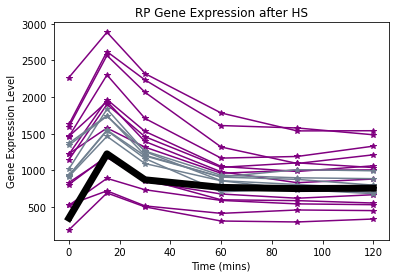

In [5]:
# Plot RP vs Rpn4 
# plot gene expression list for all genes 
x = [0, 15, 30, 60, 90 ,120] # in minutes
rpn4 = geneExprList_tot[0]
allRpns = rpnsGeneExpr
allRpts = rptsGeneExpr

# one plot per particle (CP and RP)
plt.xlabel("Time (mins)")
plt.ylabel("Gene Expression Level")
plt.title("RP Gene Expression after HS")
# -- plot cp ---
# alphas
for geneI in range(len(allRpns)):
    plt.plot(x,allRpns[geneI],'-*', color = 'purple', label = rpnsGeneNames[geneI])
# betas
for geneI in range(len(allRpts)):
    plt.plot(x,allRpts[geneI],'-*', color = 'slategray', label = rptsGeneNames[geneI])   
    
plt.plot(x,rpn4, "-*", color = 'black',linewidth = 7, label = "RPN4")
#plt.legend()
#plt.show()
plt.savefig('RP_gene_expression_'+today+'.png')
print("Figure saved!")




